# Persiapan data

In [1]:
!pip -q install hdbscan


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, v_measure_score

import hdbscan

# Opsi tampilan
pd.set_option('display.max_rows', 200)
plt.rcParams["figure.figsize"] = (7, 5)
np.random.seed(42)  # untuk reprodusibilitas tsne


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [8]:
#load data

iris = load_iris()
X = iris.data            # fitur (4 dimensi)
y = iris.target          # label asli (0=setosa, 1=versicolor, 2=virginica)
target_names = iris.target_names

print("Shape fitur:", X.shape)
print("Kelas unik:", dict(zip(range(len(target_names)), target_names)))



Shape fitur: (150, 4)
Kelas unik: {0: np.str_('setosa'), 1: np.str_('versicolor'), 2: np.str_('virginica')}


In [9]:
#Standararisasi fitur

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std[:5]


array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

# HDBSCAN clustering

> Catatan: Anda boleh mengubah min_cluster_size/min_samples jika ingin lebih/kurang ketat terhadap noise.

In [10]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,      # ukuran cluster minimum
    min_samples=None,        # jika None -> sama dengan min_cluster_size (lebih konservatif)
    metric='euclidean',
    cluster_selection_method='eom'
)
cluster_labels = clusterer.fit_predict(X_std)
cluster_probs  = clusterer.probabilities_

# Simpan ke DataFrame ringkas
df = pd.DataFrame(X, columns=['sepal_len','sepal_wid','petal_len','petal_wid'])
df['true_label']   = y
df['cluster']      = cluster_labels
df['probability']  = cluster_probs

df.head()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,sepal_len,sepal_wid,petal_len,petal_wid,true_label,cluster,probability
0,5.1,3.5,1.4,0.2,0,1,1.0
1,4.9,3.0,1.4,0.2,0,1,1.0
2,4.7,3.2,1.3,0.2,0,1,1.0
3,4.6,3.1,1.5,0.2,0,1,1.0
4,5.0,3.6,1.4,0.2,0,1,1.0


# Ringkasan hasil: jumlah cluster & noise

In [11]:
labels = cluster_labels
unique_labels = sorted([l for l in np.unique(labels) if l != -1])
n_clusters = len(unique_labels)
noise_count = int(np.sum(labels == -1))

print(f"Jumlah cluster terbentuk (tidak termasuk noise): {n_clusters}")
print(f"Banyaknya noise: {noise_count}")

# Ukuran tiap cluster
cluster_sizes = df[df['cluster']!=-1]['cluster'].value_counts().sort_index()
print("\nUkuran tiap cluster:")
display(cluster_sizes)

# (opsional) tampilkan beberapa poin noise
if noise_count > 0:
    print("\nContoh 5 baris data yang dianggap noise:")
    display(df[df['cluster']==-1].head())


Jumlah cluster terbentuk (tidak termasuk noise): 2
Banyaknya noise: 2

Ukuran tiap cluster:


,count
cluster,
0,99
1,49



Contoh 5 baris data yang dianggap noise:


,sepal_len,sepal_wid,petal_len,petal_wid,true_label,cluster,probability
117,7.7,3.8,6.7,2.2,2,-1,0.0
131,7.9,3.8,6.4,2.0,2,-1,0.0


# Evaluasi singkat vs label asli (tanpa melatih supervised)

In [12]:
# Filter penilaian hanya pada titik non-noise (agar adil terhadap keputusan HDBSCAN)
mask_non_noise = labels != -1
y_non_noise = y[mask_non_noise]
labels_non_noise = labels[mask_non_noise]

if len(np.unique(labels_non_noise)) > 1 and len(y_non_noise) > 0:
    ari = adjusted_rand_score(y_non_noise, labels_non_noise)
    v   = v_measure_score(y_non_noise, labels_non_noise)
else:
    ari, v = np.nan, np.nan

print(f"Adjusted Rand Index (tanpa noise): {ari:.3f}" if not np.isnan(ari) else "ARI: tidak terdefinisi (hanya 1 cluster atau tidak ada non-noise)")
print(f"V-measure (tanpa noise): {v:.3f}" if not np.isnan(v) else "V-measure: tidak terdefinisi")

# Pemetaan tiap cluster -> mayoritas kelas asli (untuk interpretasi)
mapping = {}
for c in unique_labels:
    true_counts = pd.Series(y[labels==c]).value_counts()
    majority_label = true_counts.idxmax()
    mapping[c] = majority_label

print("\nPemetaan cluster -> kelas mayoritas (berdasarkan non-noise):")
for c, t in mapping.items():
    print(f"  Cluster {c} ≈ {target_names[t]}")


Adjusted Rand Index (tanpa noise): 0.548
V-measure (tanpa noise): 0.694

Pemetaan cluster -> kelas mayoritas (berdasarkan non-noise):
  Cluster 0 ≈ versicolor
  Cluster 1 ≈ setosa


# Visualisasi 2D dengan PCA

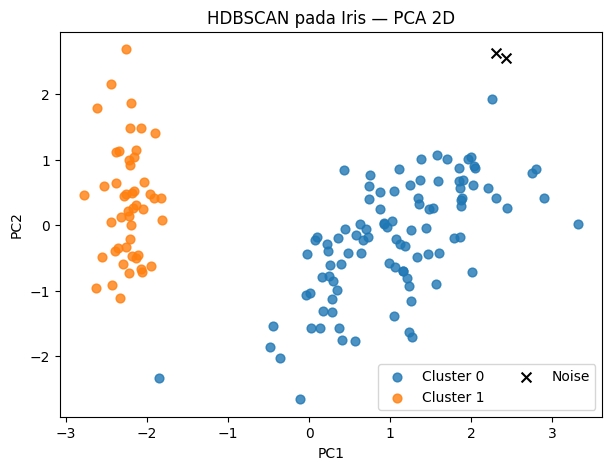

In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

# Warna untuk cluster (default colormap). Noise diberi 'x' hitam.
plt.figure()
for c in unique_labels:
    idx = (labels == c)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=40, label=f"Cluster {c}", alpha=0.8)

# Plot noise (jika ada)
idx_noise = labels == -1
if np.any(idx_noise):
    plt.scatter(X_pca[idx_noise,0], X_pca[idx_noise,1], s=50, marker='x', c='k', label='Noise')

plt.title("HDBSCAN pada Iris — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='best', ncol=2)
plt.show()


# Visualisasi 2D dengan t-SNE (opsional, lebih lambat)

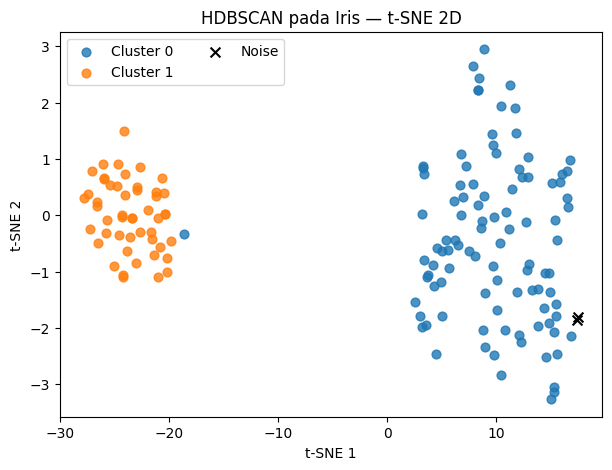

In [14]:
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
X_tsne = tsne.fit_transform(X_std)

plt.figure()
for c in unique_labels:
    idx = (labels == c)
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=40, label=f"Cluster {c}", alpha=0.8)

idx_noise = labels == -1
if np.any(idx_noise):
    plt.scatter(X_tsne[idx_noise,0], X_tsne[idx_noise,1], s=50, marker='x', c='k', label='Noise')

plt.title("HDBSCAN pada Iris — t-SNE 2D")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(loc='best', ncol=2)
plt.show()


# Analisis singkat otomatis

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


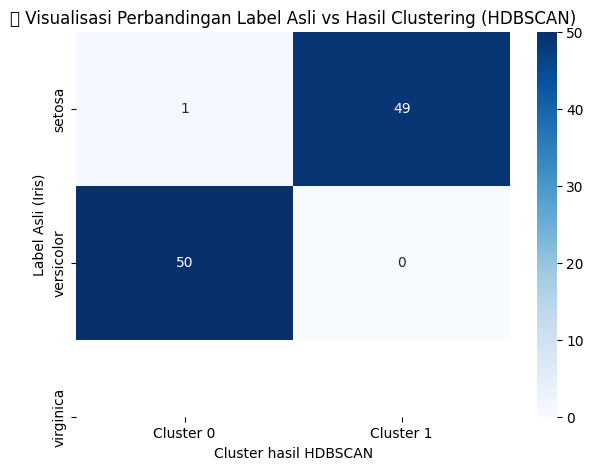

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


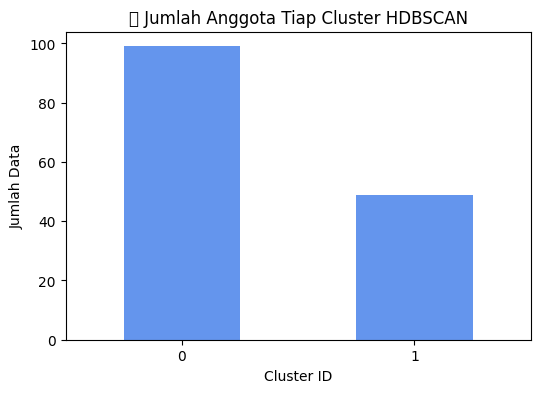

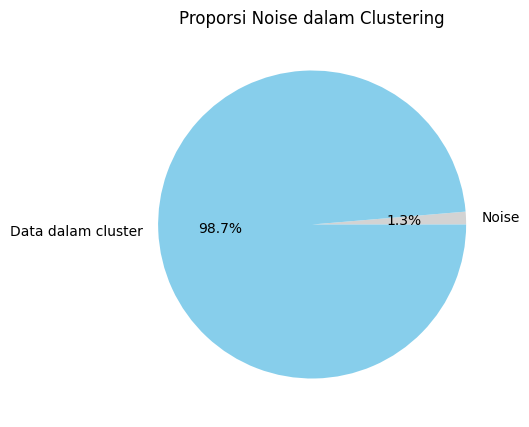

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Filter data non-noise
mask = labels != -1
true_non_noise = y[mask]
pred_non_noise = labels[mask]

# Hitung confusion matrix antar cluster vs label asli
cm = confusion_matrix(true_non_noise, pred_non_noise, labels=unique_labels)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Cluster {i}" for i in unique_labels],
            yticklabels=target_names)
plt.title("🔍 Visualisasi Perbandingan Label Asli vs Hasil Clustering (HDBSCAN)")
plt.xlabel("Cluster hasil HDBSCAN")
plt.ylabel("Label Asli (Iris)")
plt.show()

# Bar chart ukuran cluster
plt.figure(figsize=(6,4))
cluster_sizes.plot(kind='bar', color='cornflowerblue')
plt.title("📊 Jumlah Anggota Tiap Cluster HDBSCAN")
plt.xlabel("Cluster ID")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=0)
plt.show()

# Pie chart proporsi noise
plt.figure(figsize=(5,5))
plt.pie([noise_count, total - noise_count],
        labels=["Noise", "Data dalam cluster"],
        autopct='%1.1f%%',
        colors=['lightgray','skyblue'])
plt.title("Proporsi Noise dalam Clustering")
plt.show()
